In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import requests
import duckdb
from bs4 import BeautifulSoup
import os

## EV Charge Stations Per State (2010-2024)

**Data Source: Open Charge Map**

URL: https://openchargemap.org/site/develop/api#/

Data Description: "Open Charge Map's API provides access to a global database of electric vehicle charging locations. It offers a range of functionalities, including retrieving nearby charging stations, filtering stations by country, operator, or status, and contributing data such as new locations or updates. The API supports JSON and XML formats, allowing developers to integrate charging point information into apps, navigation systems, or research projects. The data is community-driven and free to use."


`ocm_us_data.csv` contains charging station data in the US. This csv file was generated by using Open Charge Map's public API. Using Postman, we sent the following HTTPS GET request (API key is ommitted):

`https://api.openchargemap.io/v3/poi?key=apikey&countrycode=US&includecomments=false&maxresults=9999999&output=csv`

The `key` parameter sets our API key so we can call the API. The `countrycode` parameter filters for US charging stations only. The `include comments` parameter removes use comments from the returned data for efficiency. The `maxresults` parameter ensures all data on US charging stations is returned (100 is default, maxresults=9999999 returns the same data as maxresults=999999 so we know our upper limit is high enough). Finally, the `output` parameter ensures our returned data is in the form of a csv file. 

To clean `ocm_us_data.csv`, we first must convert it to a `pandas.DataFrame`.

(372, 4)


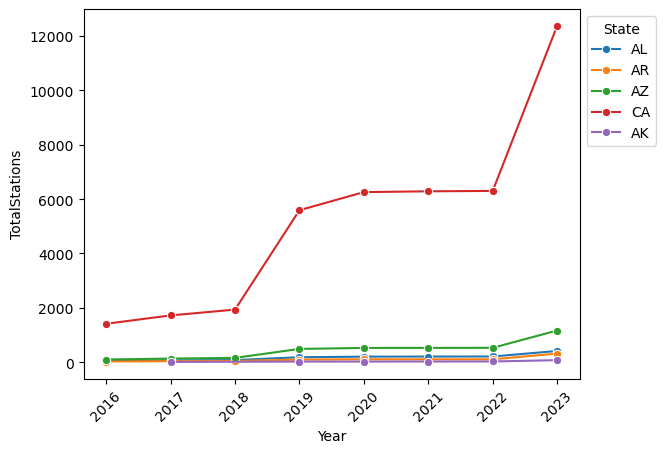

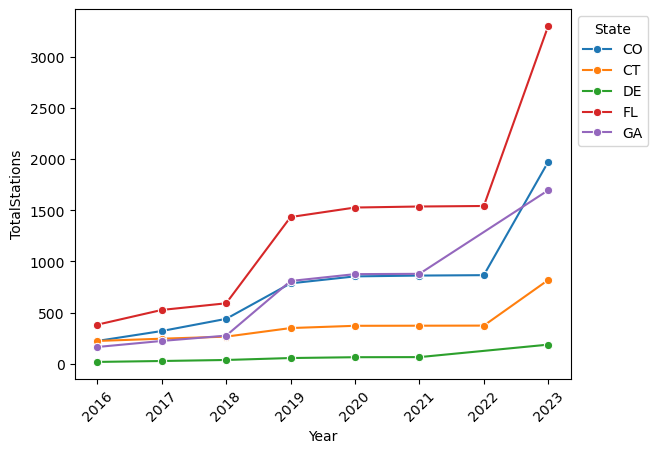

In [2]:
ocm_us_df = pd.read_csv("csv_data_files/ocm_us_data.csv", dtype={"DateLastConfirmed": 'string'})

#cleaning DateCreated column
ocm_us_df["DateCreated"] = pd.to_datetime(ocm_us_df['DateCreated'], format='%m/%d/%Y %H:%M:%S %p')
ocm_us_df["YearCreated"] = ocm_us_df["DateCreated"].dt.year

#cleaning StateOrProvince column
state_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
state_map.update({v: v for v in state_map.values()})

ocm_us_df["StateOrProvince"] = ocm_us_df["StateOrProvince"].map(state_map)
ocm_us_df = ocm_us_df[ocm_us_df["StateOrProvince"].isin(state_map.keys())]
ocm_us_df["State"] = ocm_us_df["StateOrProvince"]

ocm_us_df_grouped = duckdb.sql("SELECT State, YearCreated AS Year, \
COUNT(State) AS NewStationsCreated FROM ocm_us_df GROUP BY State, YearCreated ORDER BY Year ASC, State ASC").df()
ocm_us_df_grouped["TotalStations"] = ocm_us_df_grouped.groupby("State")["NewStationsCreated"].cumsum()

ocm_us_df_limited = ocm_us_df_grouped.loc[(ocm_us_df_grouped["Year"] > 2015) & (ocm_us_df_grouped["Year"] < 2024)]
print(ocm_us_df_limited.shape)

#splitting df to groups of states for plotting
states_to_filter = ['AL', 'AK', 'AZ', 'AR', 'CA']
ocm_us_df_limited_5 = ocm_us_df_limited[ocm_us_df_limited["State"].isin(states_to_filter)]
s = sns.lineplot(data = ocm_us_df_limited_5, \
x = "Year", y = "TotalStations", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

states_to_filter = ['CO', 'CT', 'DE', 'FL', 'GA']
ocm_us_df_limited_10 = ocm_us_df_limited[ocm_us_df_limited["State"].isin(states_to_filter)]
s = sns.lineplot(data = ocm_us_df_limited_10, \
x = "Year", y = "TotalStations", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

#etc, etc

  State  Year  TotalStations  Electric
0    AL  2016             49     500.0
1    AZ  2016             98    4700.0
2    AR  2016             24     200.0
3    CA  2016           1413  141500.0
4    CO  2016            222    5300.0
(372, 4)


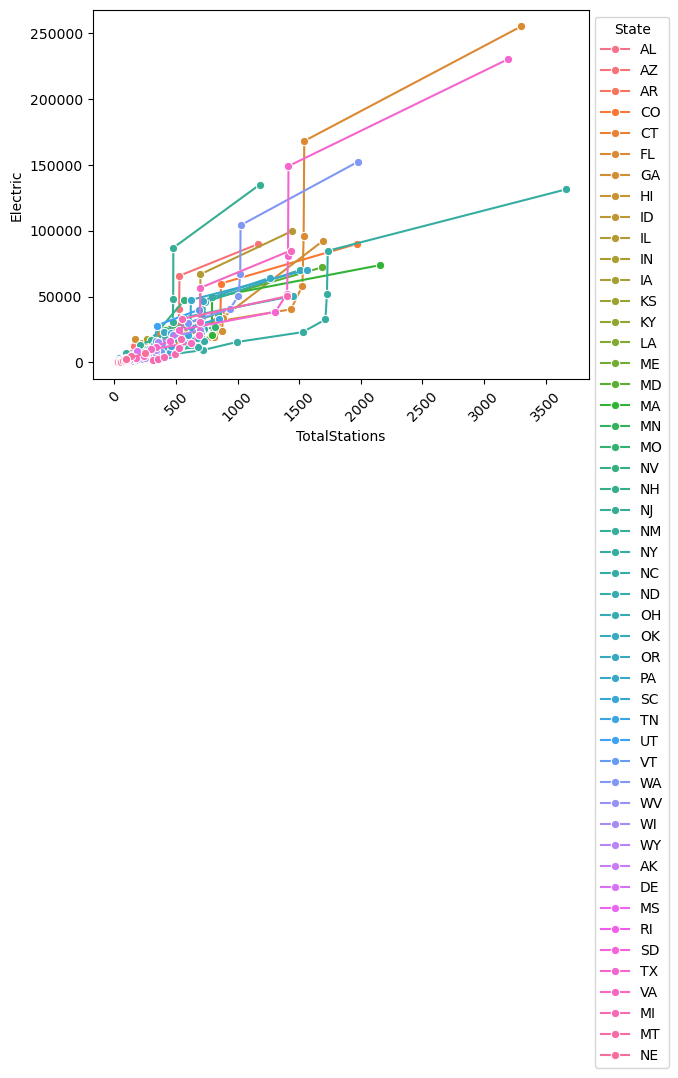

float64


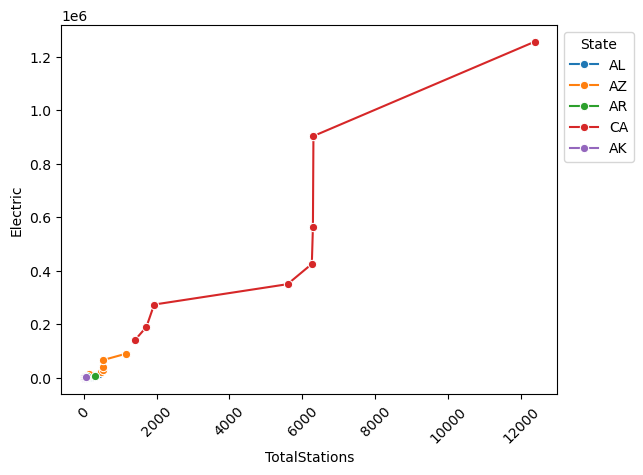

float64


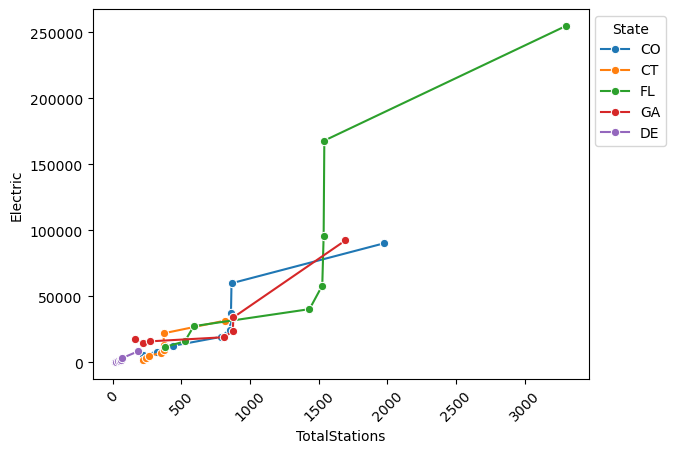

float64


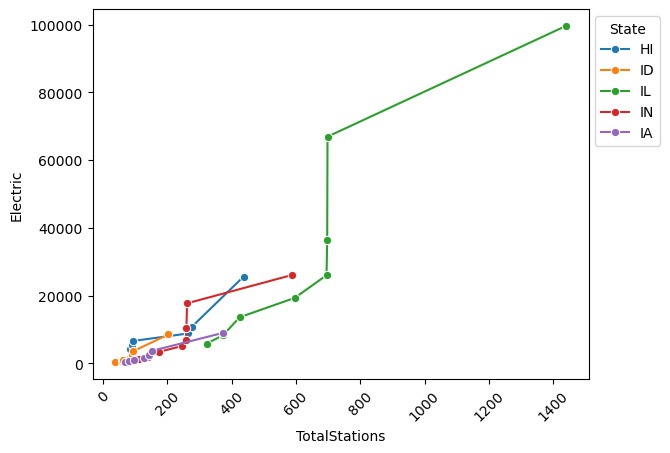

In [6]:
#comparing with registered EV data
reg_data = pd.read_csv('csv_data_files/ev_registration_data.csv')
reg_data["State"] = reg_data["State"].map(state_map)

combined_df = duckdb.sql("SELECT reg_data.State, reg_data.Year, TotalStations, Electric \
FROM ocm_us_df_limited INNER JOIN reg_data ON reg_data.Year = ocm_us_df_limited.Year AND reg_data.State = ocm_us_df_limited.State").df()
combined_df["Electric"] = combined_df["Electric"].str.replace(",", "").astype(float)

print(combined_df.head())
print(combined_df.shape)

s = sns.lineplot(data = combined_df[combined_df["State"] != "CA"], \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

#splitting df to groups of states for plotting
states_to_filter = ['AL', 'AK', 'AZ', 'AR', 'CA']
combined_df_5 = combined_df[combined_df["State"].isin(states_to_filter)]
print(combined_df_5["Electric"].dtype)
s = sns.lineplot(data = combined_df_5, \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

#splitting df to groups of states for plotting
states_to_filter = ['CO', 'CT', 'DE', 'FL', 'GA']
combined_df_10 = combined_df[combined_df["State"].isin(states_to_filter)]
print(combined_df_10["Electric"].dtype)
s = sns.lineplot(data = combined_df_10, \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

#splitting df to groups of states for plotting
states_to_filter = ['HI', 'ID', 'IL', 'IN', 'IA']
combined_df_15 = combined_df[combined_df["State"].isin(states_to_filter)]
print(combined_df_15["Electric"].dtype)
s = sns.lineplot(data = combined_df_15, \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.show()

#etc, etc